In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai import * 
from fastai.vision import *
imgsz = (256, 1600)
toy = False
bs = 4
print('a')


a


In [2]:
print('a')


a


In [3]:
path = Path("data")
testfolder = path/"test_images"
!mkdir -p /tmp/.cache/torch/checkpoints/
print('a')

a


In [4]:
import fastai

def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
print('a')
fastai.data_block.ItemLists.transform = transform

# change csv so that it has image_id on one column and rles in the 4 others
def change_csv(old):
    df = pd.read_csv(old)

    def group_func(df, i):
        reg = re.compile(r'(.+)_\d$')
        return reg.search(df['ImageId_ClassId'].loc[i]).group(1)
    group = df.groupby(lambda i: group_func(df, i))
    df = group.agg({'EncodedPixels': lambda x: list(x)})
    df['ImageId'] = df.index
    df = df.reset_index(drop=True)
    df[[f'EncodedPixels_{k}' for k in range(1, 5)]] = pd.DataFrame(df['EncodedPixels'].values.tolist())
    df = df.drop(columns='EncodedPixels')
    df = df.dropna(subset=["EncodedPixels_1", "EncodedPixels_2", "EncodedPixels_3", "EncodedPixels_4"], how="all")
    df = df.fillna(value=' ') 
    return df
print('a')
class MultiClassSegList(SegmentationLabelList):
    def open(self, id_rles):
        image_id, rles = id_rles[0], id_rles[1:]
        shape = open_image(self.path/image_id).shape[-2:]       
        final_mask = torch.zeros((1, *shape))
        for k, rle in enumerate(rles):
            if isinstance(rle, str):
                mask = open_mask_rle(rle, shape).px.permute(0, 2, 1)
                final_mask += (k + 1) * mask
        return ImageSegment(final_mask)
print('a')
def load_data(path, df):
    train_list = (SegmentationItemList
                  .from_df(df, path=path/"train_images")
                  .split_by_rand_pct(valid_pct=0.2)
                  .label_from_df(cols=list(range(5)), label_cls=MultiClassSegList, classes=[0, 1, 2, 3, 4])
                  .add_test(testfolder.ls(), label=None)
                  .transform(get_transforms(flip_vert=True), size=imgsz, tfm_y=True)
                  .databunch(bs=bs, num_workers=0))
    return train_list
print('a')
def dice(input:Tensor, targs:Tensor, eps:float=1e-8)->Rank0Tensor:
    input = input.clone()
    targs = targs.clone()
    n = targs.shape[0]
    input = torch.softmax(input, dim=1).argmax(dim=1)
    input = input.view(n, -1)
    targs = targs.view(n, -1)
    input[input == 0] = -999
    intersect = (input == targs).sum().float()
    union = input[input > 0].sum().float() + targs[targs > 0].sum().float()
    del input, targs
    gc.collect()
    return ((2.0 * intersect + eps) / (union + eps)).mean()
print('a')
def visualize_one(a, b, c, title):
    fig, ax = plt.subplots(3, 1, figsize=(15, 7))
    ax[0].set_title(title)
    ax[0].imshow(a.permute(1, 2, 0))
    ax[1].imshow(b.squeeze(), vmin=0, vmax=4)
    ax[2].imshow(c.squeeze(), vmin=0, vmax=4)
    ax[0].set_axis_off()
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    plt.show()
print('a')   
def visualize_some():
    n_batch = 0
    for batch in learn.data.train_dl:
        x, y = batch
        n_batch += 1
        if n_batch > 8:
            break
        for idx in range(bs):
            predimg, pred, _ = learn.predict(Image(x[idx].cpu()))
            visualize_one(x[idx], y[idx], pred, f"Index: {idx}")
    plt.tight_layout()
print('a')    
def print_stats(learn):
    print("Plotting Losses")
    learn.recorder.plot_losses()
    print("Plotting metrics")
    learn.recorder.plot_metrics()
    print("Plotting LR")
    learn.recorder.plot_lr()
    print("Validation losses")
    print(learn.recorder.val_losses)
    print("Metrics")
    print(learn.recorder.metrics)
print('a')

a
a
a
a
a
a
a
a


In [5]:
df = change_csv(path/"train.csv")
if toy:
    df = df.sample(200)
data = load_data(path, df)
del df
import gc
gc.collect()
!nvidia-smi

Wed Sep 11 15:06:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 435.21       Driver Version: 435.21       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:01:00.0  On |                  N/A |
| 35%   30C    P8    33W / 260W |    919MiB / 11018MiB |     25%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [6]:
learn =unet_learner(data, models.resnet34, metrics=[dice])
print('a')

a


In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


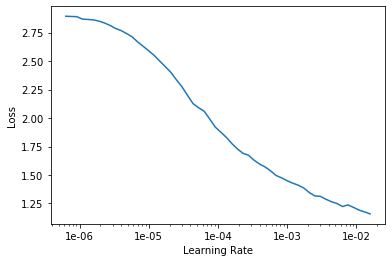

In [8]:
learn.recorder.plot()

In [9]:
!nvidia-smi
learn.fit_one_cycle(7, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,dice,time
0,0.184348,0.167158,0.101985,14:58
1,0.207339,0.175608,0.186597,14:54
2,0.166043,0.135978,0.185892,14:52
3,0.147254,0.118713,0.200771,14:54
4,0.119692,0.108389,0.205247,14:51
5,0.111736,0.102369,0.202370,14:50
6,0.117246,0.101515,0.205597,14:51


In [10]:
learn.save("resnet34-stage1")


In [11]:
learn.unfreeze()

In [12]:
learn.fit_one_cycle(6, max_lr=slice(1e-6, 1e-4))


epoch,train_loss,valid_loss,dice,time
0,0.122462,0.101693,0.205660,15:18
1,0.109306,0.101092,0.202621,15:19
2,0.095853,0.102943,0.202510,15:19
3,0.121919,0.098040,0.211914,15:19
4,0.104244,0.098430,0.208299,15:20
5,0.105838,0.098199,0.207101,15:21


In [13]:
learn.save("resnet34-stage2")


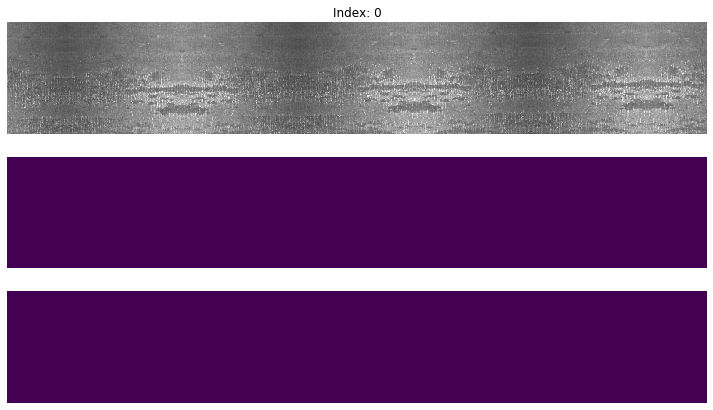

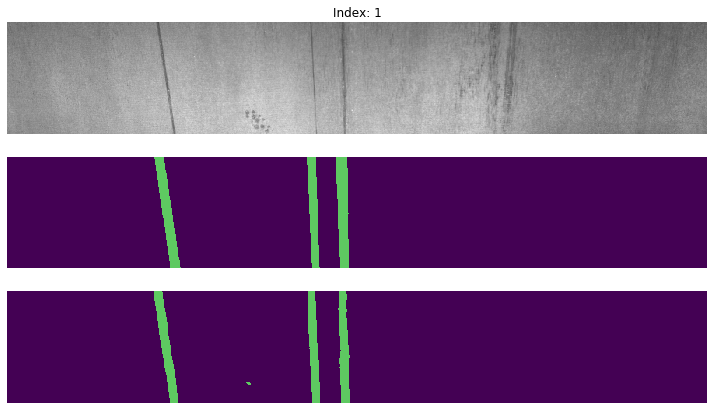

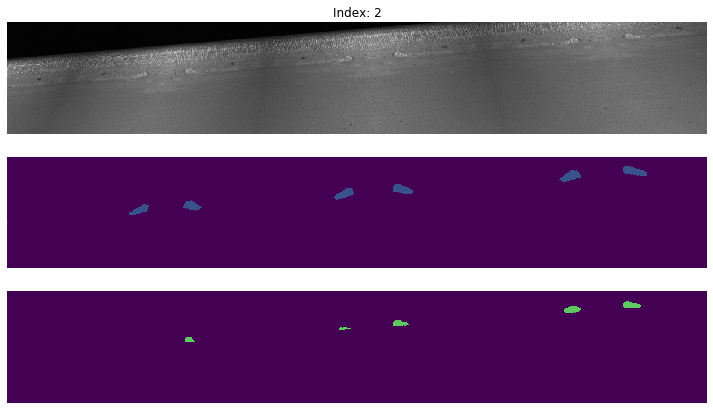

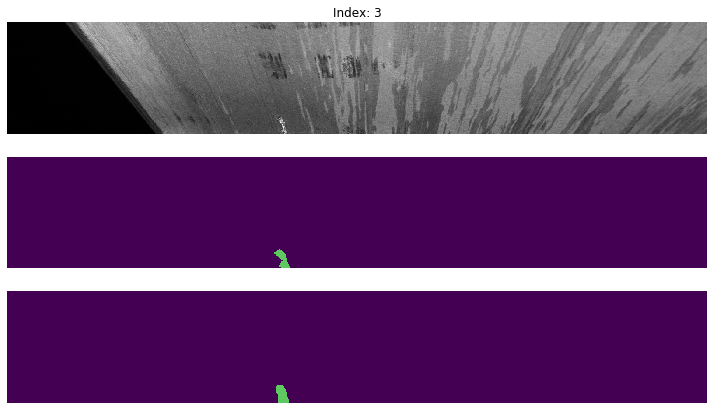

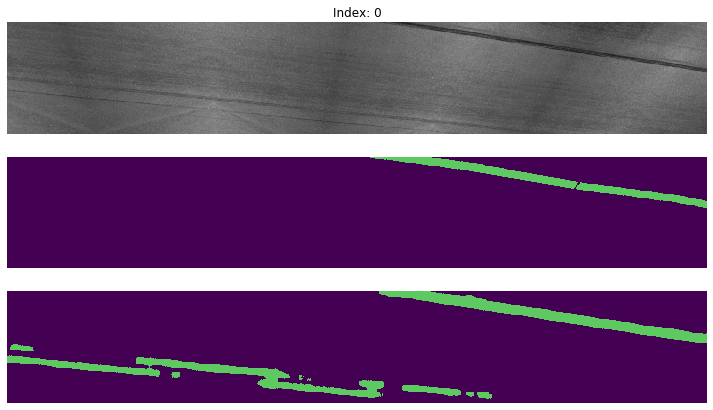

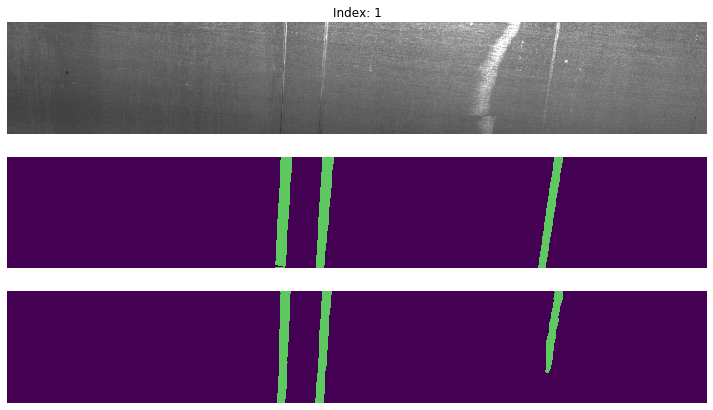

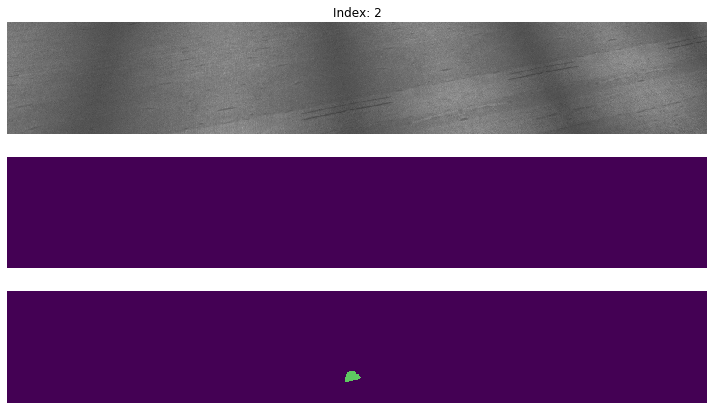

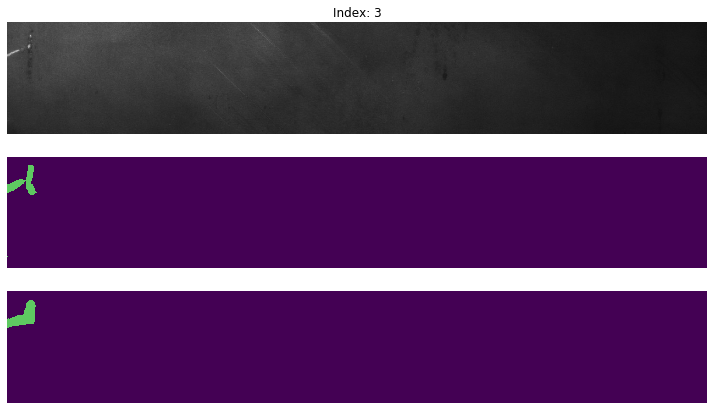

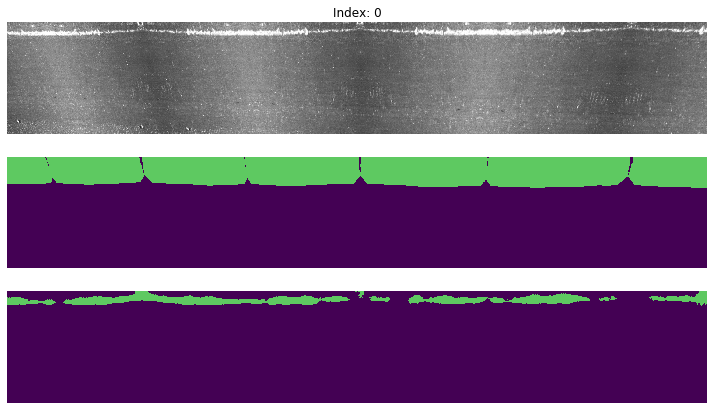

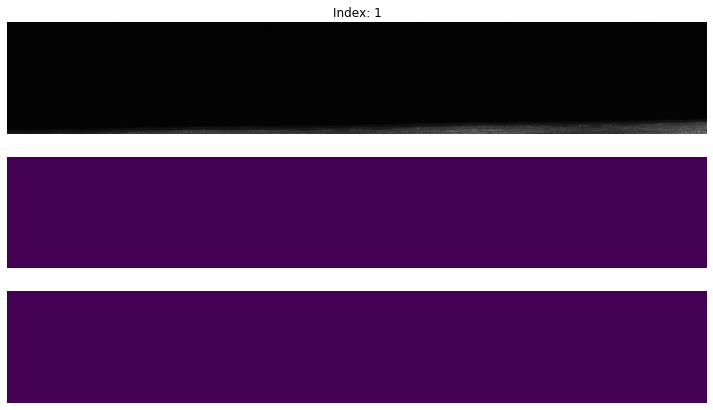

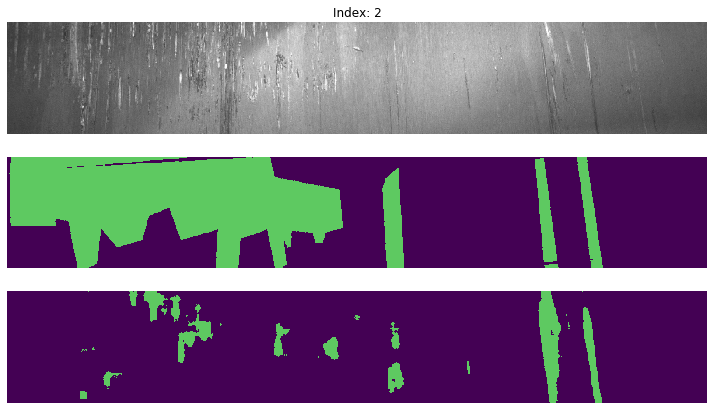

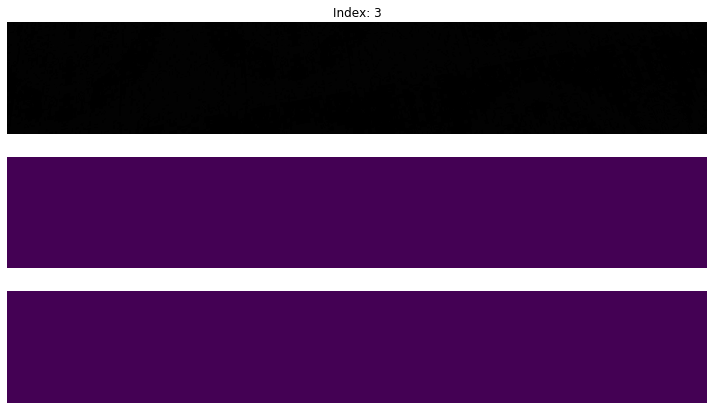

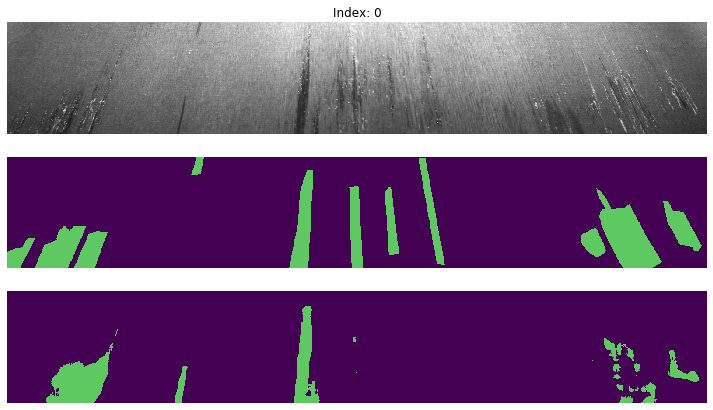

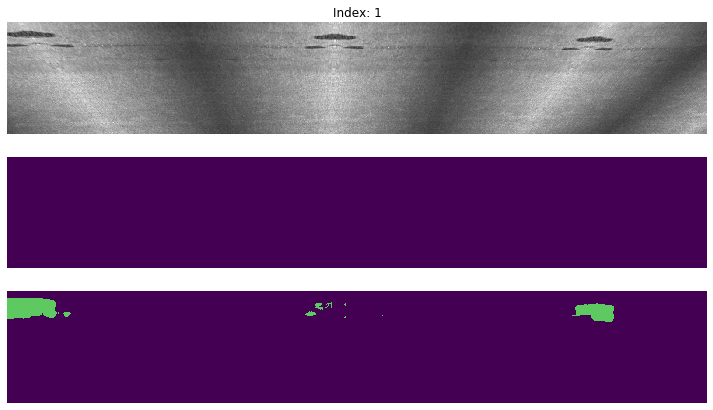

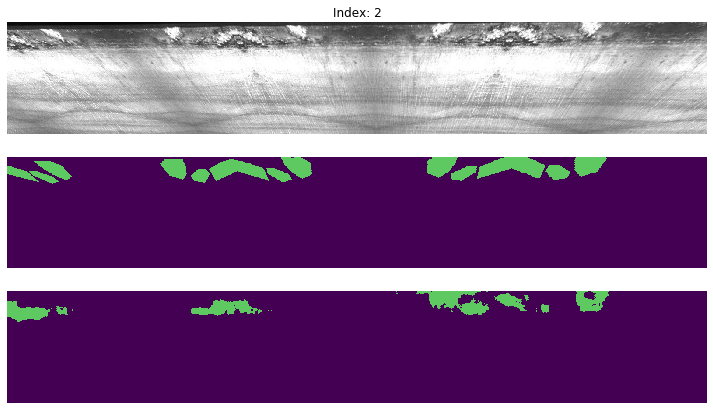

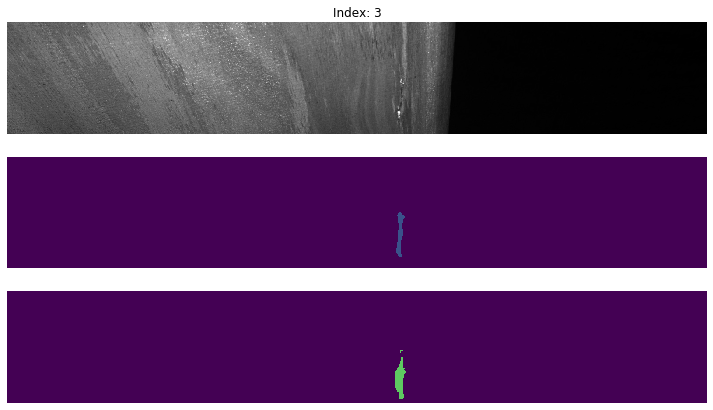

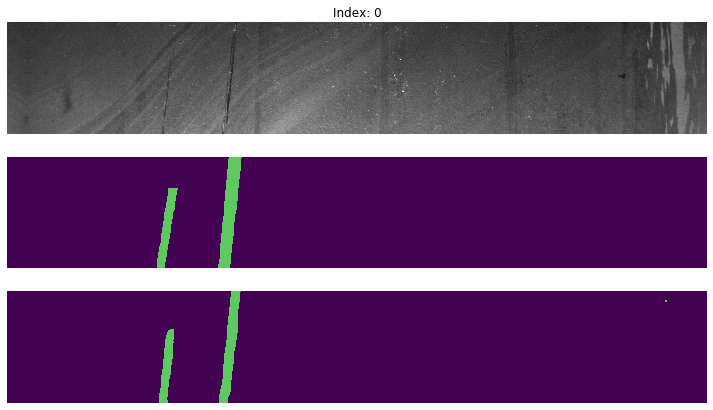

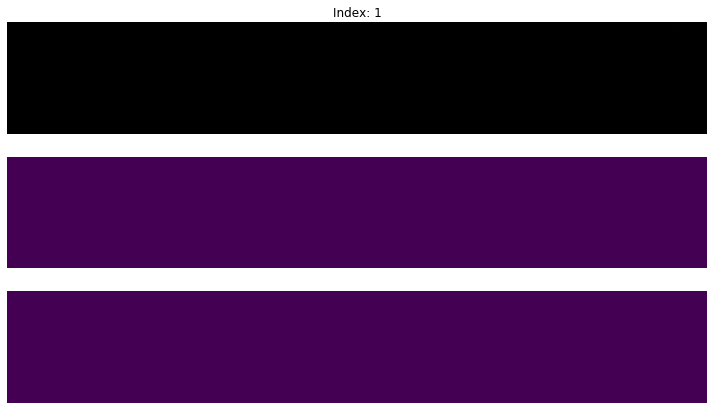

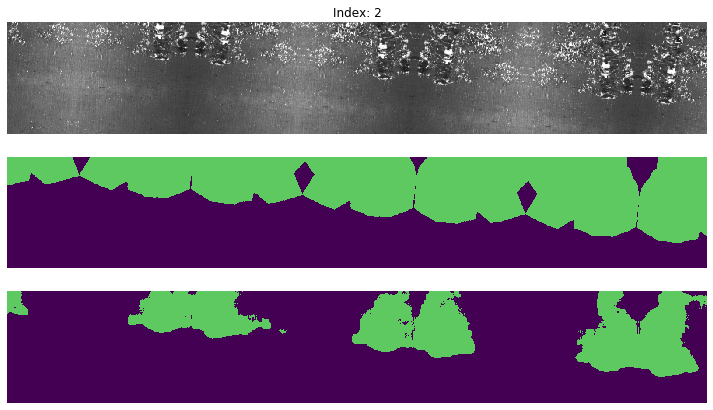

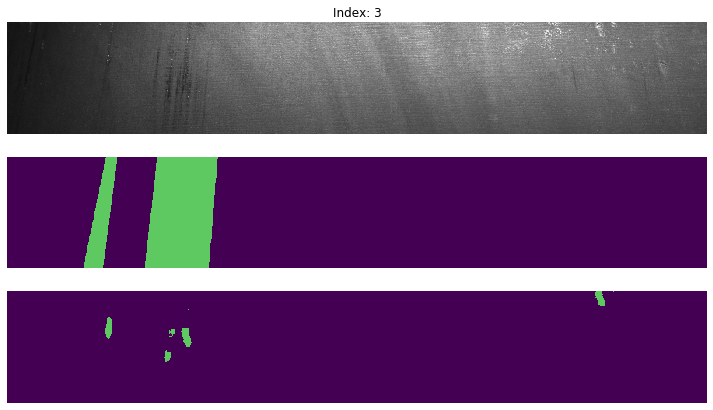

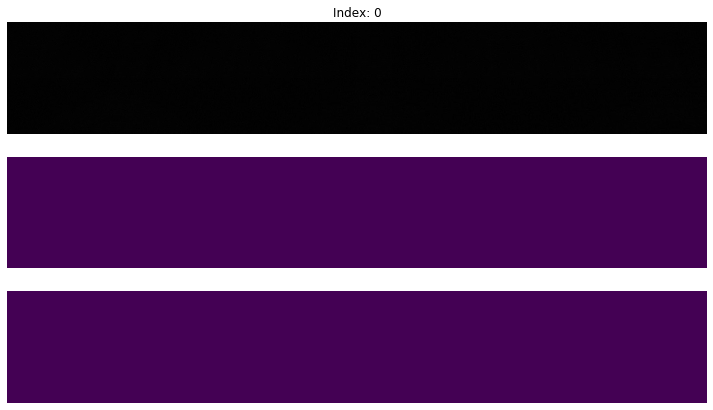

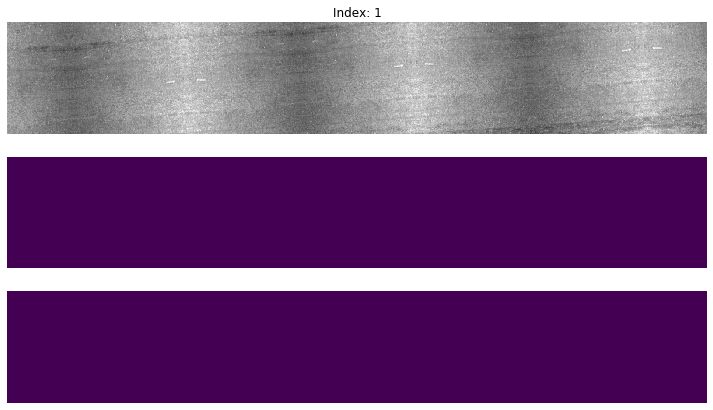

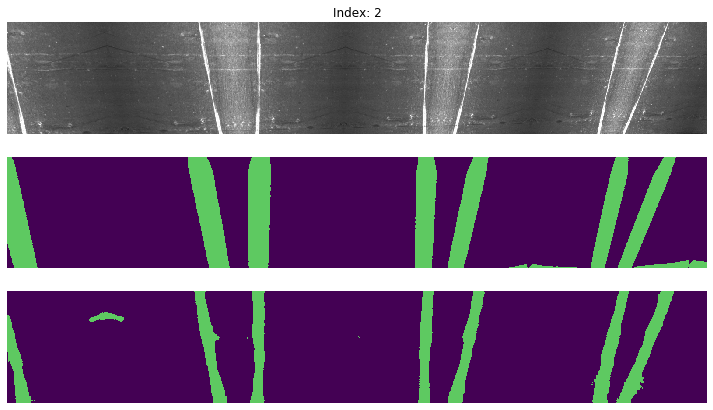

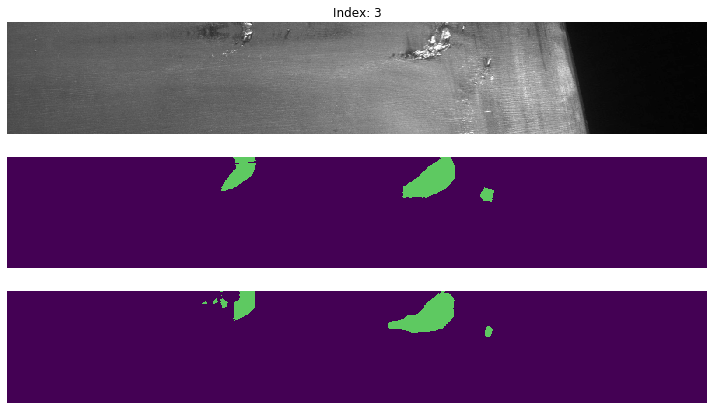

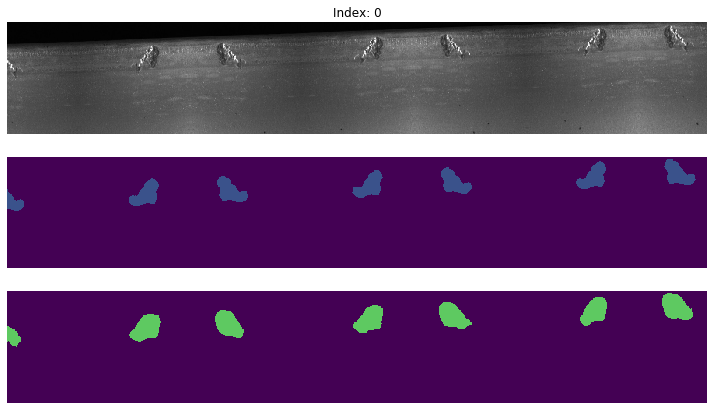

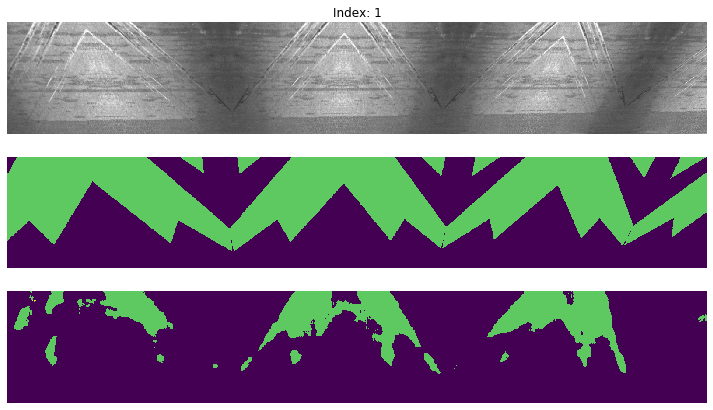

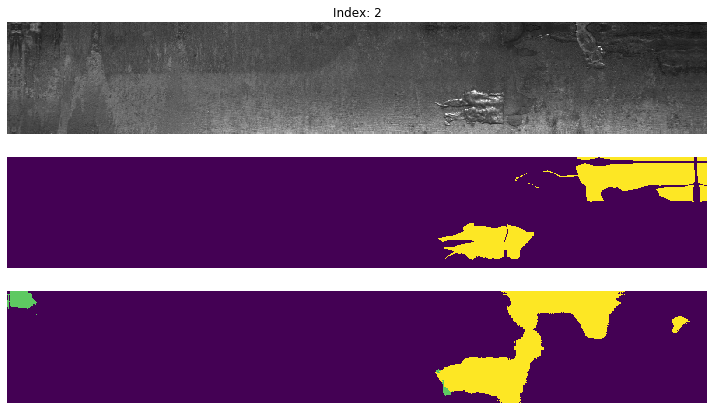

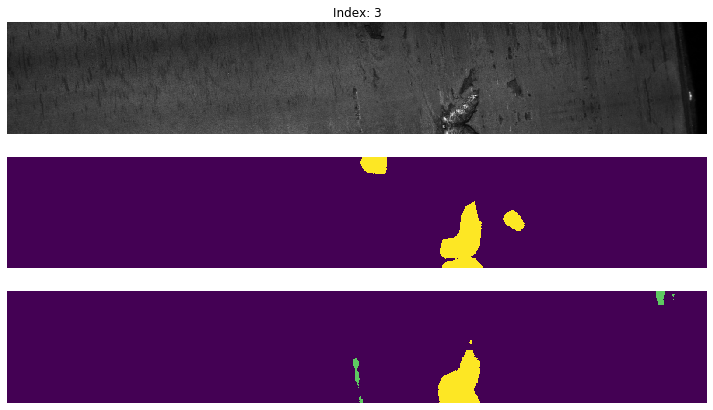

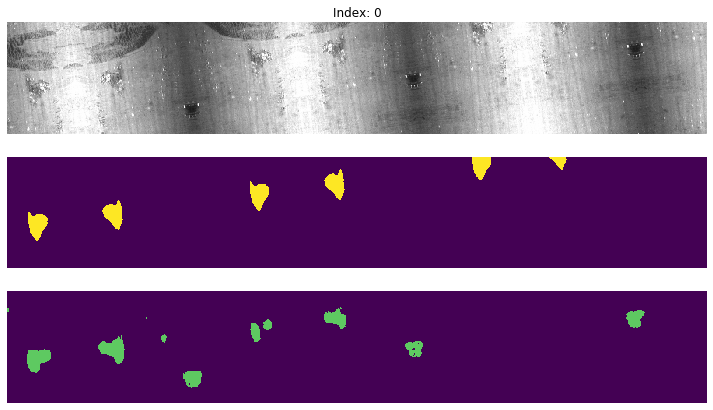

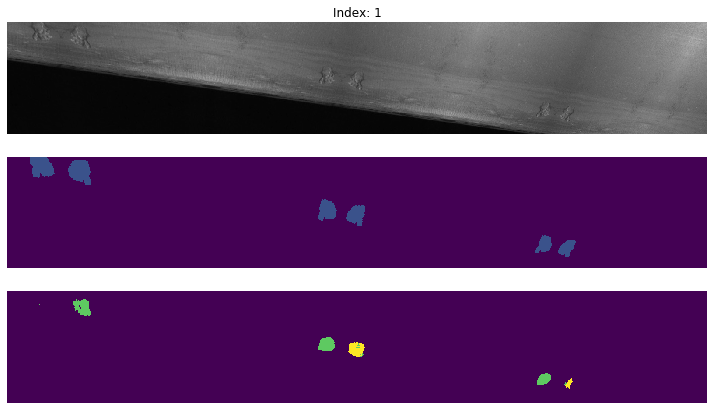

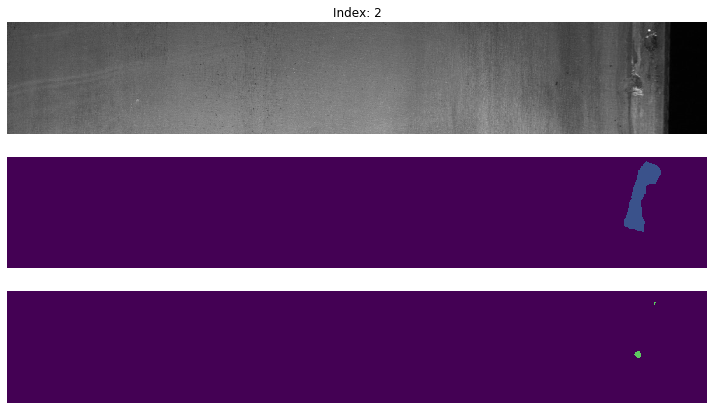

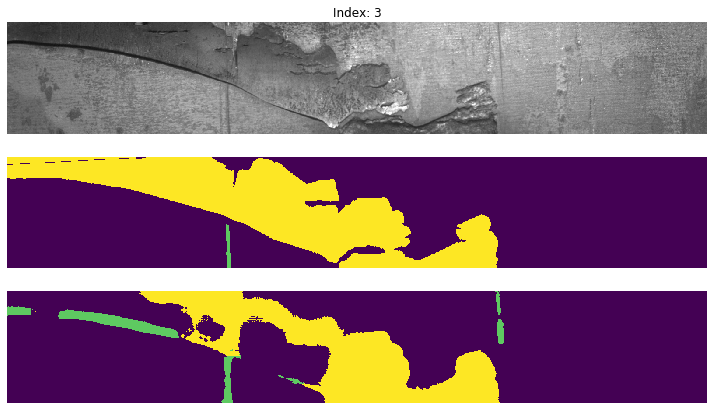

<Figure size 432x288 with 0 Axes>

In [14]:
visualize_some()
